In [15]:
%%writefile src/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for 
LIBS benchmark classification dataset.
"""

import os
import torch
from torch.utils.data import DataLoader
from load_libs_data import load_contest_train_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler
from siamese_net import prepare_triplets
import numpy as np


NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    #test_dir: str, 
    batch_size: int, 
    device: torch.device,
    num_workers: int=NUM_WORKERS, 
    split_rate: float=0.6,
    random_st: int=102,
    spectra_count: int=100
    ):
    """Creates training and validation DataLoaders.

    Takes in a training directory directory path and split the data
    to train/validation. After, it turns them into PyTorch Datasets and 
    then into PyTorch DataLoaders.

    Args:
    train_dir: Path to training directory.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

    Returns:
    A tuple of (train_dataloader, test_dataloader, class_labels).
    Example usage:
        train_dataloader, test_dataloader, class_labels, wavelengths = \
        = create_dataloaders(train_dir=path/to/train_dir,
                                test_dir=path/to/test_dir,
                                transform=some_transform,
                                batch_size=32,
                                num_workers=4)
    """



    X, y, samples = load_contest_train_dataset(train_dir, spectra_count)
    wavelengths = X.columns

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_rate, random_state=random_st, stratify=samples, shuffle = True)
    del X, y, samples

    if True:
      scaler =  Normalizer(norm = 'max')
      X_train = scaler.fit_transform(X_train)
      X_val = scaler.fit_transform(X_val)

    # Convert data to torch tensors
    X_train = torch.from_numpy(X_train).unsqueeze(1).float() # Add extra dimension for channels
    X_val = torch.from_numpy(X_val).unsqueeze(1).float() # Add extra dimension for channels
    y_train = torch.from_numpy(np.array(y_train)).long()
    y_val = torch.from_numpy(np.array(y_val)).long()

    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # If available, move data to the GPU
    X_train.to(device)
    X_val.to(device) 
    y_train.to(device)
    y_val.to(device)

    # Prepare triplets for the training, validation
    train_triplets = prepare_triplets(X_train, y_train)
    val_triplets = prepare_triplets(X_val, y_val)


    # Create PyTorch DataLoader objects for the training and validation sets
    train_dataloader = DataLoader(train_triplets, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_triplets, batch_size=batch_size, shuffle=True)


    return train_dataloader, val_dataloader, y_train


Overwriting src/data_setup.py


In [10]:
%%writefile src/engine.py
"""
Contains functions for training and validating a PyTorch model.
"""
import torch
import wandb
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
        model: A PyTorch model to be trained.
        dataloader: A DataLoader instance for the model to be trained on.
        loss_fn: A PyTorch loss function to minimize.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
        training loss
    """
    model.train()
    # Initialize running loss and number of batches for the training dataset
    running_loss_train = 0.0
    num_batches_train = 0

    # Iterate over the training data loader
    for i, data in enumerate(dataloader, 0):
        # Get the inputs and labels for the current batch
        inputs = [input.to(device) for input in data]
        
        input_a = inputs[0]
        input_p = inputs[1]
        input_n = inputs[2]
        
        # Compute the embeddings for the current batch
        outputs = model(input_a, input_p, input_n)


        # Split the embeddings into anchor, positive, and negative examples
        anchor = outputs[0]
        positive = outputs[1]
        negative = outputs[2]
        
        # Compute the triplet loss for the current batch
        loss_train = loss_fn(anchor, positive, negative)

        # Backpropagate the loss and update the network parameters
        loss_train.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update the running loss and number of batches for the training dataset
        running_loss_train += loss_train.item()
        num_batches_train += 1

    # Compute the average loss for the training dataset
    epoch_loss_train = running_loss_train / num_batches_train
    return epoch_loss_train

def val_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               device: torch.device):
    """validates a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    test loss

    """
    model.eval() 


    # Initialize running loss and number of batches for the validation dataset
    running_loss_val = 0.0
    num_batches_val = 0

    # Turn on inference context manager
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            # Get the inputs and labels for the current batch

            inputs_val = [input.to(device) for input in data]

            input_a = inputs_val[0]
            input_p = inputs_val[1]
            input_n = inputs_val[2]
            # Compute the embeddings for the current batch
            outputs = model(input_a, input_p, input_n)

            # Split the embeddings into anchor, positive, and negative examples
            anchor = outputs[0]
            positive = outputs[1]
            negative = outputs[2]

            # Compute the triplet loss for the current batch
            loss_val = loss_fn(anchor, positive, negative)

            # Update the running loss and number of batches for the validation dataset
            running_loss_val += loss_val.item()
            num_batches_val += 1

    # Compute the average loss for the validation dataset
    epoch_loss_val = running_loss_val / num_batches_val
    return epoch_loss_val

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          val_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and validates a PyTorch model.

  Passes a target PyTorch models through train_step() and val_step()
  functions for a number of epochs, training and validating the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    val_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and validating loss as well as training and
    validating accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  val_loss: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  val_loss: [1.2641, 1.5706]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [], "val_loss": []}

  wandb.init(project='siamese_net_contest', entity='jakubv')
  wandb.watch(model)  
  # Loop through training and validating steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss = train_step(model=model,
                            dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device)
      val_loss = val_step(model=model,
                            dataloader=val_dataloader,
                            loss_fn=loss_fn,
                            device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"val_loss: {val_loss:.4f} "
      )
      wandb.log({
        "epoch": epoch+1,
        "training_loss": train_loss, 
        "validation_loss": val_loss
        })  
      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["val_loss"].append(val_loss)
  wandb.finish()  
  # Return the filled results at the end of the epochs
  return results

Overwriting src/engine.py


In [11]:
%%writefile src/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Overwriting src/utils.py


In [16]:
%%writefile src/train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import torch
import data_setup, engine, siamese_net, utils
import numpy as np
import torch.nn as nn


# Setup hyperparameters
NUM_EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.0001
INPUT_SIZE = 40000
CHANNELS=50
KERNEL_SIZES=[50, 10]
STRIDES=[2, 2]
PADDINGS=[1, 1]
HIDDEN_SIZES=[256]

# Setup directories
train_dir = "datasets/contest_TRAIN.h5"
#test_dir = "datasets/test.h5"

# Setup target device
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")

# Create DataLoaders with help from data_setup.py
train_dataloader, val_dataloader, train_labels = data_setup.create_dataloaders(
    train_dir=train_dir,
    #test_dir=test_dir,
    batch_size=BATCH_SIZE,
    device = device
)

# Create model with help from siamese_net.py
# margin = 1.0

model = siamese_net.SiameseNetwork(
    input_size=INPUT_SIZE, 
    output_size=len(np.unique(train_labels)), 
    channels=CHANNELS, 
    kernel_sizes=KERNEL_SIZES, 
    strides=STRIDES, 
    paddings=PADDINGS, 
    hidden_sizes=HIDDEN_SIZES
).to(device)

# Set loss and optimizer
loss_fn = nn.TripletMarginLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model=model,
             train_dataloader=train_dataloader,
             val_dataloader=val_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="modularity_test1.pth")

Overwriting src/train.py


In [ ]:
# %%writefile src/test_data.py
# """
# Contains functionality for creating PyTorch DataLoaders for 
# LIBS benchmark classification dataset.
# """

# import os
# import torch
# from torch.utils.data import DataLoader
# from load_libs_data import load_contest_train_dataset
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import Normalizer, MinMaxScaler
# from siamese_net import prepare_triplets
# import numpy as np


# NUM_WORKERS = os.cpu_count()

# def create_dataloaders(
#     train_dir: str, 
#     #test_dir: str, 
#     batch_size: int, 
#     device: torch.device,
#     num_workers: int=NUM_WORKERS, 
#     split_rate: float=0.6,
#     random_st: int=102,
#     spectra_count: int=100
#     ):
#     """Creates training and validation DataLoaders.

#     Takes in a training directory directory path and split the data
#     to train/validation. After, it turns them into PyTorch Datasets and 
#     then into PyTorch DataLoaders.

#     Args:
#     train_dir: Path to training directory.
#     batch_size: Number of samples per batch in each of the DataLoaders.
#     num_workers: An integer for number of workers per DataLoader.

#     Returns:
#     A tuple of (train_dataloader, test_dataloader, class_labels).
#     Example usage:
#         train_dataloader, test_dataloader, class_labels, wavelengths = \
#         = create_dataloaders(train_dir=path/to/train_dir,
#                                 test_dir=path/to/test_dir,
#                                 transform=some_transform,
#                                 batch_size=32,
#                                 num_workers=4)
#     """



#     X, y, samples = load_contest_train_dataset(train_dir, spectra_count)
#     wavelengths = X.columns

#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_rate, random_state=random_st, stratify=samples, shuffle = True)
#     del X, y, samples

#     if True:
#       scaler =  Normalizer(norm = 'max')
#       X_train = scaler.fit_transform(X_train)
#       X_val = scaler.fit_transform(X_val)

#     # Convert data to torch tensors
#     X_train = torch.from_numpy(X_train).unsqueeze(1).float() # Add extra dimension for channels
#     X_val = torch.from_numpy(X_val).unsqueeze(1).float() # Add extra dimension for channels
#     y_train = torch.from_numpy(np.array(y_train)).long()
#     y_val = torch.from_numpy(np.array(y_val)).long()

#     #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     # If available, move data to the GPU
#     X_train.to(device)
#     X_val.to(device) 
#     y_train.to(device)
#     y_val.to(device)

#     # Prepare triplets for the training, validation
#     train_triplets = prepare_triplets(X_train, y_train)
#     val_triplets = prepare_triplets(X_val, y_val)


#     # Create PyTorch DataLoader objects for the training and validation sets
#     train_dataloader = DataLoader(train_triplets, batch_size=batch_size, shuffle=True)
#     val_dataloader = DataLoader(val_triplets, batch_size=batch_size, shuffle=True)


#     return train_dataloader, val_dataloader, y_train


In [52]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# import funcs
# import importlib
# importlib.reload(funcs)
# from funcs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from src.load_libs_data import load_contest_test_dataset

path = 'datasets/contest_TEST.h5'

X_test = load_contest_test_dataset(path)



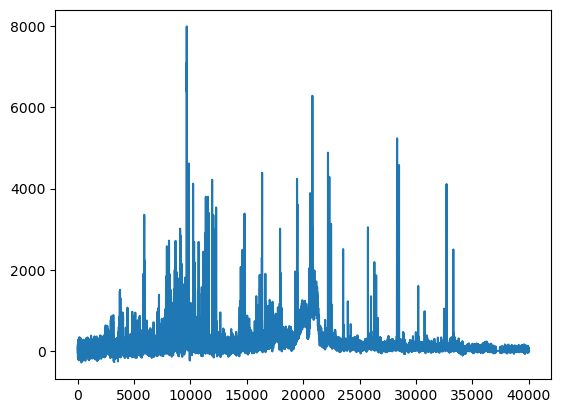

In [6]:
X_test.shape

import matplotlib.pyplot as plt
plt.plot(X_test.iloc[1,:])

In [5]:
# !pip install pipreqs
import pipreqs
!python -m  pipreqs.pipreqs

INFO: Successfully saved requirements file in c:\Users\kubov\Documents\git_projects\similarity_metrics\requirements.txt


In [11]:
%%writefile src/prediction_engine.py
"""
Contains functionality for creating PyTorch DataLoaders for 
LIBS benchmark classification dataset.
"""

import os
import torch
from torch.utils.data import DataLoader
from load_libs_data import load_contest_test_dataset, load_contest_train_dataset
from sklearn.preprocessing import Normalizer, MinMaxScaler
import numpy as np


def create_dataloaders(
    test_dir: str, 
    test_labels_dir: str, 
    batch_size: int, 
    device: torch.device,
    pred_test: bool,
    ):
    """Creates training and validation DataLoaders.

    Takes in a training directory directory path and split the data
    to train/validation. After, it turns them into PyTorch Datasets and 
    then into PyTorch DataLoaders.

    Args:
    train_dir: Path to training directory.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

    Returns:
    A tuple of (train_dataloader, test_dataloader, class_labels).
    Example usage:
        train_dataloader, test_dataloader, class_labels, wavelengths = \
        = create_dataloaders(train_dir=path/to/train_dir,
                                test_dir=path/to/test_dir,
                                transform=some_transform,
                                batch_size=32,
                                num_workers=4)
    """

    if pred_test:
        X_test = load_contest_test_dataset(test_dir)
        y_test = np.loadtxt(test_labels_dir, delimiter = ',')
    else: # use with caution, only for predicting training embeddings
        X_test, y_test, _ = load_contest_train_dataset(test_dir)

    if True:
      scaler =  Normalizer(norm = 'max')
      X_test = scaler.fit_transform(X_test)

    # Convert data to torch tensors
    X_test = torch.from_numpy(X_test).unsqueeze(1).float() # Add extra dimension for channels
    y_test = torch.from_numpy(np.array(y_test)).long()


    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # If available, move data to the GPU
    X_test.to(device)
    y_test.to(device)



    # Create PyTorch DataLoader objects for the training and validation sets
    pred_test_loader = DataLoader(X_test, batch_size=batch_size)


    return pred_test_loader, y_test

def predict_test(
                model: torch.nn.Module, 
                dataloader: torch.utils.data.DataLoader,
                device: torch.device,
                test_dir: str, 
                test_labels_dir: str,
                batch_size: int,
                y_test
                ):
    X_test_pred=[]
    with torch.no_grad():
        for data in dataloader:
            input = data.to(device)
            output = (model.forward_once(input)).cpu()
            output = np.array(output)
            X_test_pred.append(output)
    X_test_pred = np.concatenate(X_test_pred, axis = 0)
    return X_test_pred






Overwriting src/prediction_engine.py


In [19]:
%%writefile src/prediction.py

import torch
import prediction_engine
import siamese_net
import numpy as np

NUM_EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.0001
INPUT_SIZE = 40000
OUTPUT_SIZE = 12
CHANNELS=50
KERNEL_SIZES=[50, 10]
STRIDES=[2, 2]
PADDINGS=[1, 1]
HIDDEN_SIZES=[256]

# Setup directories
#test_dir = "datasets/contest_TEST.h5"
test_labels_dir = "datasets/test_labels.csv"
model_dir = 'models/modularity_test1.pth'
test_dir = "datasets/contest_TRAIN.h5"


# Setup target device
device = torch.device("cpu")

# Create DataLoaders with help from data_setup.py
test_dataloader, y_test = prediction_engine.create_dataloaders(
    test_dir=test_dir,
    test_labels_dir=test_labels_dir,
    batch_size=BATCH_SIZE,
    device = device,
    pred_test = True # USE WITH CAUTION, turn to 'False' if you want to get embeddings of the training data
)


saved_state_dict = torch.load(model_dir, map_location=torch.device('cpu'))

# Create a new instance of your model
model = siamese_net.SiameseNetwork(
    input_size=INPUT_SIZE, 
    output_size=OUTPUT_SIZE, 
    channels=CHANNELS, 
    kernel_sizes=KERNEL_SIZES, 
    strides=STRIDES, 
    paddings=PADDINGS, 
    hidden_sizes=HIDDEN_SIZES
).to(device)
# Load the saved state into the new model instance
model.load_state_dict(saved_state_dict)

#todo save this to a file
prediction_X_test = prediction_engine.predict_test(
                    model=model, 
                    dataloader=test_dataloader,
                    device=device,
                    test_dir=test_dir, 
                    test_labels_dir=test_labels_dir,
                    batch_size=BATCH_SIZE,
                    y_test=y_test
                    )


np.save('datasets/prediction_X_test2.npy', prediction_X_test)        
np.save('datasets/y_test.npy', y_test)          

#https://colab.research.google.com/drive/15D5vAYkhbAs5-txhYTCb_Fp2jiCnHXVN#scrollTo=82F_qINOBbkL

Overwriting src/prediction.py


In [17]:
import numpy as np
test = np.load('datasets/prediction_X_test.npy')
test.shape

(20000, 12)